In [23]:
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as cPickle
import xarray as xr

from driftutils import keep_in_domain as kid
from driftutils.utils import wrap_to_180

%matplotlib inline

def load_data(fname, pdir=None):
    if pdir:
        pname = os.path.basename(fname)
        pfile = os.path.join(pdir, pname)
        if os.path.exists(pfile):
            ds = load_pickle(pfile)
        else:
            with xr.load_dataset(fname) as ds:
                save_pickle(pfile, ds)
        return ds
    
def save_pickle(fname, data):
    print('Creating ' + os.path.basename(fname))
    with open(fname, 'wb') as handle:
        cPickle.dump(data, handle)

def load_pickle(fname):
    print('Loading ' + os.path.basename(fname))
    with open(fname, 'rb') as handle:
        loaded_data = cPickle.load(handle)
    return loaded_data

# the data used by the user grid drift tool example
usergridfile = ("/home/sdfo000/sitestore7/opp_drift_fa3/share_drift/RIOPS-PS-sample/"
                + "2019091400_023_3D_ps5km60N.nc")
# the data used by the nemo grid drift tool example
nemogridfile = ("/home/sdfo000/sitestore7/opp_drift_fa3/share_drift/CIOPSE_SN1500/CIOPSE_2D_1h/"
                 + "NEMO_RPN_1h_grid_U_2D_20161010-20161010.nc")
# the salish sea data
salseafile = ("/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/input_data/SalishSea/currents/"
              + "Salish-Sea_2D-Wave-Fields_currents_20230217T00-20230224T1130.nc")
# directory where the pickle files will be saved
pdir = ("/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/input_data/SalishSea/"
        + "jupyter_notebook_input/confirm_model_input_data/pickled_files")

In [24]:
usergrid = load_data(usergridfile, pdir)
nemogrid = load_data(nemogridfile, pdir)
salsea = load_data(salseafile, pdir)

Loading 2019091400_023_3D_ps5km60N.nc
Loading NEMO_RPN_1h_grid_U_2D_20161010-20161010.nc
Loading Salish-Sea_2D-Wave-Fields_currents_20230217T00-20230224T1130.nc


In [25]:
salsea

<xarray.Dataset>
Dimensions:    (time: 360, latitude: 661, longitude: 572)
Coordinates:
  * time       (time) datetime64[ns] 2023-02-17 ... 2023-02-24T11:30:00
  * latitude   (latitude) float32 48.0 48.0 48.01 48.01 ... 50.96 50.97 50.97
  * longitude  (longitude) float32 234.0 234.0 234.0 234.0 ... 238.0 238.0 238.0
Data variables:
    ucur       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vcur       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/41)
    acknowledgement:               Fisheries & Oceans Canada, MEOPAR, ONC, Co...
    area:                          SoG_BCgrid_00500m
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    creator_email:                 gemmrich@uvic.ca
    creator_name:                  Salish Sea MEOPAR Project Contributors
    ...                            ...
    time_coverage_end:             2023-02-24T11:30:00Z
    time_coverage_start:           2023-02-17T00:00:00Z
    title:                         Forecast, Salish Sea, 2d Wave Fields, 30mi...
    WAVEWATCH_III_switches:        IS0 IC0 REF1 RWND DIST MPI UQ PR3 LN1 FLX0...
    WAVEWATCH_III_version_number:  5.16
    Westernmost_Easting:           234.0

In [26]:
usergrid

<xarray.Dataset>
Dimensions:              (xc: 1770, yc: 1610, depth: 75, time: 1)
Coordinates:
  * xc                   (xc) float32 0.0 5e+03 1e+04 ... 8.84e+06 8.845e+06
  * yc                   (yc) float32 0.0 5e+03 1e+04 ... 8.04e+06 8.045e+06
    latitude             (yc, xc) float32 30.56 30.58 30.61 ... 41.54 41.5 41.47
    longitude            (yc, xc) float32 221.3 221.3 221.3 ... 20.93 20.9 20.87
  * depth                (depth) float32 0.5075 1.558 ... 5.698e+03 5.902e+03
  * time                 (time) datetime64[ns] 2019-09-14T23:00:00
Data variables:
    polar_stereographic  |S1 b''
    votemper             (time, depth, yc, xc) float32 nan nan nan ... nan nan
    vosaline             (time, depth, yc, xc) float32 nan nan nan ... nan nan
    vozocrtx             (time, depth, yc, xc) float32 nan nan nan ... nan nan
    vomecrty             (time, depth, yc, xc) float32 nan nan nan ... nan nan
Attributes:
    Conventions:      CF-1.6
    title:            Time-averaged sea ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Ocean Prediction System version 2.0.0
    product_version:  RIOPS_2.0.0_F3
    creation_date:    2019-Sep-14 08:59:32 UTC
    contact:          production-info@ec.gc.ca

In [28]:
def set_up_map_plot(ax):
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'},
                 linewidth=2, color='gray', alpha=0.1, 
                 linestyle='-', zorder=1)
    return ax


def create_subplots_figure(nrows=1, ncols=1, map=False, fsize=None, ratio=1.5, axsize=6):
    """ratio is expected to be width/height so that a ratio of 2 will
    give a plot that is twice as wide as it is tall"""
    if not fsize:
        fsize = (ratio*(axsize*nrows), axsize*ncols)
    if map:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize,
                                subplot_kw={'projection': crs.PlateCarree()})
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize)
    return fig, axs.flatten()

In [29]:
times = ss.time.values
lats = ss.latitude.values
lons = wrap_to_180(ss.longitude.values)
ucurs = ss.ucur.values
vcurs = ss.vcur.values

bbox = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
xv, yv = np.meshgrid(lons, lats)
dummy = np.ones([len(xv), len(xv[0])])
edge_lons, edge_lats = kid.find_edges(xv, yv, 0)

In [30]:
fig, axs = create_subplots_figure(nrows=1, ncols=1, axsize=5)
ax = axs[0]

# the initial run start times
ax.axhline(times[47], linewidth=0.5)
ax.axhline(times[97], linewidth=0.5)
# the time period covered in the data file
ax.plot(times[::10], 'o', color='b', markersize=3)
ax.set_title('times')

Text(0.5, 1.0, 'times')

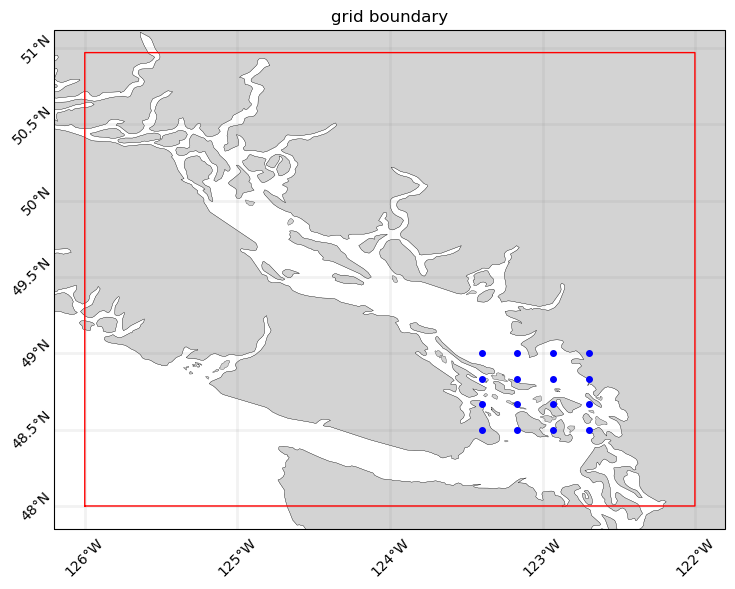

In [31]:
# these are the lats and lons that the drift-tool tries to include in the experiment:
initial_lons = [-123.4, -123.16666667, -122.93333333, -122.7, -123.4, -123.16666667, -122.93333333, -122.7, -123.4, 
                -123.16666667, -122.93333333, -122.7, -123.4, -123.16666667, -122.93333333, -122.7]
initial_lats = [48.5, 48.5, 48.5, 48.5, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.83333333, 
                48.83333333, 48.83333333, 48.83333333, 49, 49, 49, 49]

fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True)
ax = axs[0]
set_up_map_plot(ax)
ax.set_title('grid boundary')

ax.plot(edge_lons, edge_lats, color='r', linestyle='-', linewidth=1)

ax.plot(initial_lons, initial_lats, 'o', color='b', markersize=4)

plt.tight_layout()